In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from src.helpers import create_treemap_data
from src.data_loader import *

# Categories Structure

In [5]:
df_categories = read_categories()
df_categories

,article,category,level_1,level_2,level_3
0,Áedán mac Gabráin,subject.History.British History.British Histor...,History,British History,British History 1500 and before including Roma...
1,Áedán mac Gabráin,subject.People.Historical figures,People,Historical figures,None
2,Åland,subject.Countries,Countries,None,None
3,Åland,subject.Geography.European Geography.European ...,Geography,European Geography,European Countries
4,Édouard Manet,subject.People.Artists,People,Artists,None
...,...,...,...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical elements,Science,Chemistry,Chemical elements
5200,Zoroaster,subject.People.Religious figures and leaders,People,Religious figures and leaders,None
5201,Zuid-Gelders,subject.Geography.European Geography,Geography,European Geography,None
5202,Zuid-Gelders,subject.Language and literature.Languages,Language and literature,Languages,None


In [6]:
# Count artices with multiple categories
df_categories['article'].value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

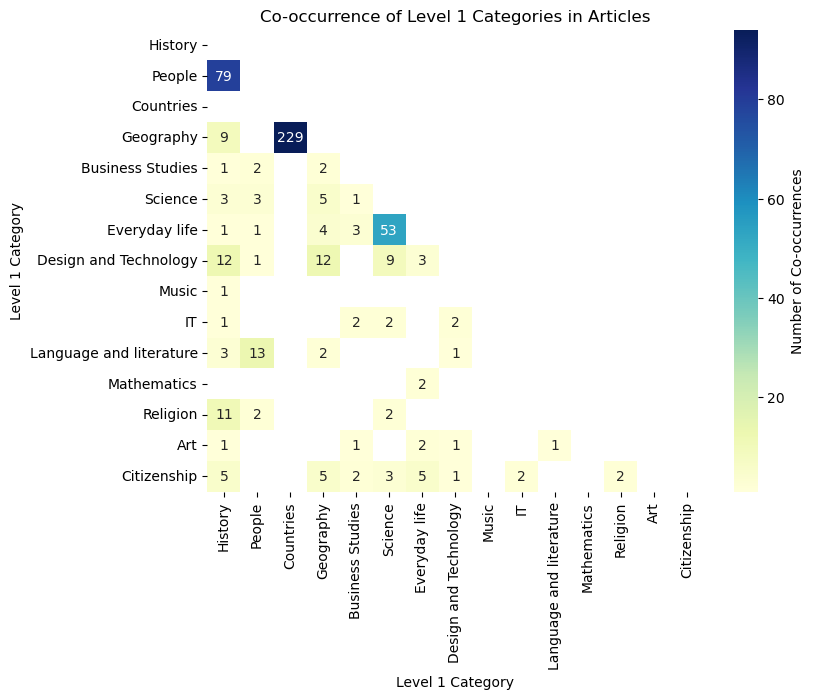

,Category Pair,Articles,Article Count
0,"(Geography, Countries)","[Åland, Éire, Abkhazia, Abu Dhabi, Afghanistan...",229
1,"(People, History)","[Áedán mac Gabráin, Óengus I of the Picts, Akh...",79
2,"(Science, Everyday life)","[Almond, Aquarium, Avocado, Barley, Basil, Bea...",53
3,"(People, Language and literature)","[Augusta, Lady Gregory, Benjamin Britten, Coll...",13
4,"(Design and Technology, History)","[Avro Lancaster, Castra, Colossus of Rhodes, F...",12


In [7]:
# Step 1: Filter articles with multiple categories
multi_category_articles = df_categories.groupby('article').filter(lambda x: len(x) > 1)

# Step 2: Create pairs of category co-occurrences for each article with multiple categories
category_pairs = []
article_pairs = defaultdict(list)  # Dictionary to store articles for each unique category pair

for article in multi_category_articles['article'].unique():
    categories = multi_category_articles[multi_category_articles['article'] == article]['level_1'].unique()
    for pair in combinations(categories, 2):
        pair_set = frozenset(pair)  # Use a frozenset to ignore order
        category_pairs.append(pair_set)
        article_pairs[pair_set].append(article)  # Add the article to the respective pair list

# Step 3: Count the occurrences of each pair
pair_counts = Counter(category_pairs)

# Step 4: Convert pair_counts to a DataFrame for heatmap plotting
categories = df_categories['level_1'].unique()
heatmap_data = pd.DataFrame(0, index=categories, columns=categories)

# Step 5: Fill in the DataFrame with pair counts
for pair, count in pair_counts.items():
    cat1, cat2 = list(pair)
    heatmap_data.loc[cat1, cat2] = count
    heatmap_data.loc[cat2, cat1] = count  # Ensure symmetry

# Now, article_pairs contains each unique pair (unordered) with the list of associated articles

# Step 6: Plot the heatmap with a mask for the upper triangle, excluding zeros
mask = np.triu(np.ones_like(heatmap_data, dtype=bool)) | (heatmap_data == 0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", mask=mask,                      
            cbar_kws={'label': 'Number of Co-occurrences'}, fmt="g", robust=True)
plt.title("Co-occurrence of Level 1 Categories in Articles")
plt.xlabel("Level 1 Category")
plt.ylabel("Level 1 Category")
plt.show()

# Step 7: Convert article_pairs dictionary to a DataFrame with category pairs as sets and associated articles
article_pairs_df = pd.DataFrame([(pair, articles) for pair, articles in article_pairs.items()],
                                columns=['Category Pair', 'Articles'])

article_pairs_df['Article Count'] = article_pairs_df['Articles'].apply(len)  # Add count of articles
article_pairs_df = article_pairs_df.sort_values(by='Article Count', ascending=False).reset_index(drop=True)

# Display the DataFrame containing unique category pairs as sets and associated articles
article_pairs_df.head()


In [36]:
labels, parents, values, ids = create_treemap_data(df_categories)
print(labels,"\n",parents,"\n",values,"\n", ids)

['Art', 'Business Studies', 'Citizenship', 'Countries', 'Design and Technology', 'Everyday life', 'Geography', 'History', 'IT', 'Language and literature', 'Mathematics', 'Music', 'People', 'Religion', 'Science', 'Art', 'Artists', 'Business', 'Companies', 'Currency', 'Economics', 'Animal and Human Rights', 'Community organisations', 'Conflict and Peace', 'Culture and Diversity', 'Education', 'Environment', 'Law', 'Media', 'Politics and government', 'Air and Sea transport', 'Architecture', 'Engineering', 'Railway transport', 'Road transport', 'Cartoons', 'Computer and Video games', 'Drink', 'Everyday life', 'Films', 'Food and agriculture', 'Games', 'Recreation', 'Sports', 'Sports events', 'Sports teams', 'Television', 'African Geography', 'Antarctica', 'Central and South American Geography', 'Climate and the Weather', 'European Geography', 'General Geography', 'Geography of Asia', 'Geography of Great Britain', 'Geography of Oceania Australasia', 'Geography of the Middle East', 'Geology a

In [37]:
# Plotting the treemap
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
    #textinfo="label+value",  # Show both label and value
    textfont=dict(size=18),  # Increase font size; will automatically fit smaller labels

))
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), title="Category Distribution in Articles (Some articles have multiple categories, thus the sum of values is greater than the number of articles)")
fig.show()

In [38]:
fig = go.Figure(go.Sunburst(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
))

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), title="Category Distribution in Articles (Some articles have multiple categories, thus the sum of values is greater than the number of articles)")
fig.show()

In [35]:
# Step 1: Count the number of articles in each category
category_counts = df_categories.groupby('level_1')['article'].nunique().reset_index()
category_counts.columns = ['level_1', 'count']

# Step 2: Merge category counts back to df_categories
df_categories_with_counts = df_categories.merge(category_counts, on='level_1')

# Step 3: Sort by 'count' to ensure the most specific (lowest count) category is first, then drop duplicates
df_categories_filtered = df_categories_with_counts.sort_values('count').drop_duplicates('article', keep='first')

# Step 4: Drop the 'count' column if no longer needed
df_categories_filtered = df_categories_filtered.drop(columns=['count']).reset_index(drop=True)

# Display the modified DataFrame with only the most specific category per article
df_categories_filtered

labels_filtered, parents_filtered, values_filtered, ids_filtered = create_treemap_data(df_categories_filtered)
print(labels,"\n",parents,"\n",values,"\n", ids)

# Plotting the treemap
fig = go.Figure(go.Treemap(
    labels=labels_filtered,
    parents=parents_filtered,
    values=values_filtered,
    ids=ids_filtered,
    textfont=dict(size=18),  # Increase font size; will automatically fit smaller labels
))

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), title="Category Distribution in Articles (Only the most specific category is shown for each article)")
fig.show()

['Art', 'Business Studies', 'Citizenship', 'Countries', 'Design and Technology', 'Everyday life', 'Geography', 'History', 'IT', 'Language and literature', 'Mathematics', 'Music', 'People', 'Religion', 'Science', 'Art', 'Artists', 'Business', 'Companies', 'Currency', 'Economics', 'Animal and Human Rights', 'Community organisations', 'Conflict and Peace', 'Culture and Diversity', 'Education', 'Environment', 'Law', 'Media', 'Politics and government', 'Air and Sea transport', 'Architecture', 'Engineering', 'Railway transport', 'Road transport', 'Cartoons', 'Computer and Video games', 'Drink', 'Everyday life', 'Films', 'Food and agriculture', 'Games', 'Recreation', 'Sports', 'Sports events', 'Sports teams', 'Television', 'African Geography', 'Antarctica', 'Central and South American Geography', 'Climate and the Weather', 'European Geography', 'General Geography', 'Geography of Asia', 'Geography of Great Britain', 'Geography of Oceania Australasia', 'Geography of the Middle East', 'Geology a

In [40]:
# Assume 'article_list' is your list of articles to check
missing_articles = [article for article in read_articles() if article not in df_categories_filtered['article'].values]

# Display missing articles
print("Missing articles (without category):", missing_articles)


Missing articles (without category): ['Pikachu']


# Paths

In [92]:
df_finished = read_finished_paths()
df_unfinished = read_unfinished_paths()

In [87]:
def build_network(df_paths, df_categories, weight_threshold=5):
    """
    Build a directed network graph from paths with main categories and edge weights.
    """
    # Map each article to its main category
    article_to_main_category = dict(zip(df_categories['article'], df_categories['level_1']))

    # Initialize directed graph
    G = nx.DiGraph()

    # Build the network with main categories and aggregate edge weights
    for path in df_paths['path']:
        nodes = path.split(';')
        main_category_nodes = [article_to_main_category.get(node, node) for node in nodes]

        for i in range(len(main_category_nodes) - 1):
            if main_category_nodes[i] != main_category_nodes[i + 1]:  # Avoid self-loops
                if G.has_edge(main_category_nodes[i], main_category_nodes[i + 1]):
                    G[main_category_nodes[i]][main_category_nodes[i + 1]]['weight'] += 1
                else:
                    G.add_edge(main_category_nodes[i], main_category_nodes[i + 1], weight=1)

    return G

def filter_network(G, weight_threshold=5, top_n=None):
    """
    Filter the network based on weight threshold and top connections.
    """
    # Apply weight threshold
    filtered_edges = [(u, v) for u, v, weight in G.edges(data='weight') if weight >= weight_threshold]
    H = G.edge_subgraph(filtered_edges).copy()

    # Limit each node to its top_n strongest connections, if specified
    if top_n is not None:
        for node in list(H.nodes):
            edges = sorted(H.edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)
            if len(edges) > top_n:
                edges_to_remove = edges[top_n:]
                H.remove_edges_from([(u, v) for u, v, _ in edges_to_remove])

    return H

def plot_network(H, title="Network Graph", node_size=700):
    """
    Plot the network graph with specified title.
    """
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(H, seed=42, k=0.5)  # Adjust 'k' for node spacing
    plt.gca().set_facecolor("white")  # Set background to white

    # Draw nodes, edges, and labels
    nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color="skyblue", edgecolors="black")
    nx.draw_networkx_edges(H, pos, width=[min(H[u][v]['weight'] * 0.2, 5) for u, v in H.edges()], alpha=0.7, arrows=True)
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight="bold")

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()

def analyze_edge_weights(G):
    """
    Analyze and plot the distribution of edge weights, and return statistical thresholds.
    """
    edge_weights = [weight for u, v, weight in G.edges(data='weight')]

    # Plot the distribution of edge weights
    plt.figure(figsize=(8, 6))
    plt.hist(edge_weights, bins=30, color="skyblue", edgecolor="black")
    plt.xlabel("Edge Weight")
    plt.ylabel("Frequency")
    plt.title("Distribution of Edge Weights")
    plt.show()

    # Calculate statistical thresholds
    mean_weight = np.mean(edge_weights)
    median_weight = np.median(edge_weights)
    percentile_75 = np.percentile(edge_weights, 75)
    percentile_90 = np.percentile(edge_weights, 90)

    print(f"Mean Weight: {mean_weight}")
    print(f"Median Weight: {median_weight}")
    print(f"75th Percentile: {percentile_75}")
    print(f"90th Percentile: {percentile_90}")

    return mean_weight, median_weight, percentile_75, percentile_90

def plot_network_with_thresholds(G, thresholds):
    """
    Plot the network for different weight thresholds for comparison.
    """
    for threshold in thresholds:
        H = filter_network(G, weight_threshold=threshold)
        
        # Visualize the graph for each threshold
        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(H, seed=42)
        nx.draw(H, pos, with_labels=True, node_size=500, font_size=10, edge_color="skyblue")
        plt.title(f"Graph with Weight Threshold = {threshold}")
        plt.show()

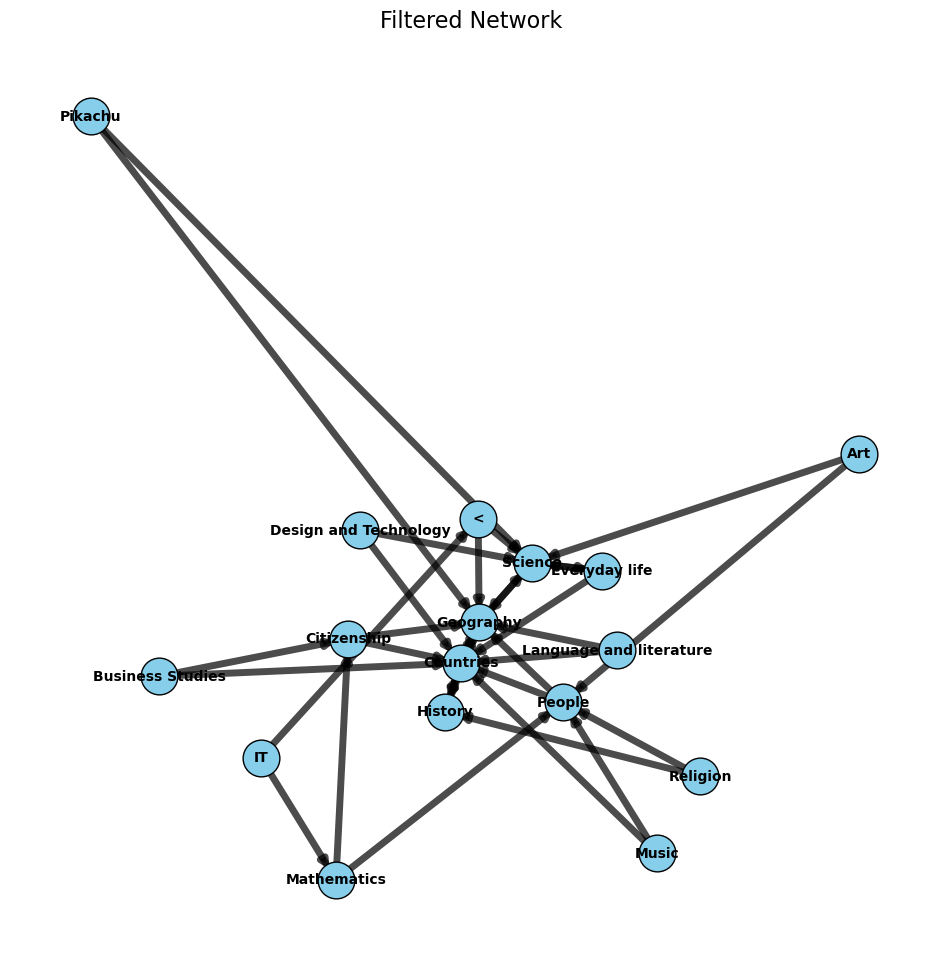

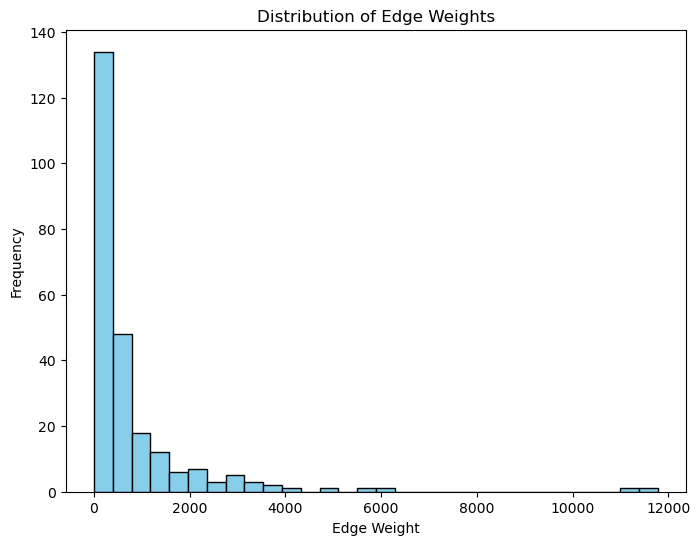

Mean Weight: 768.9098360655738
Median Weight: 311.0
75th Percentile: 796.25
90th Percentile: 2013.3000000000004


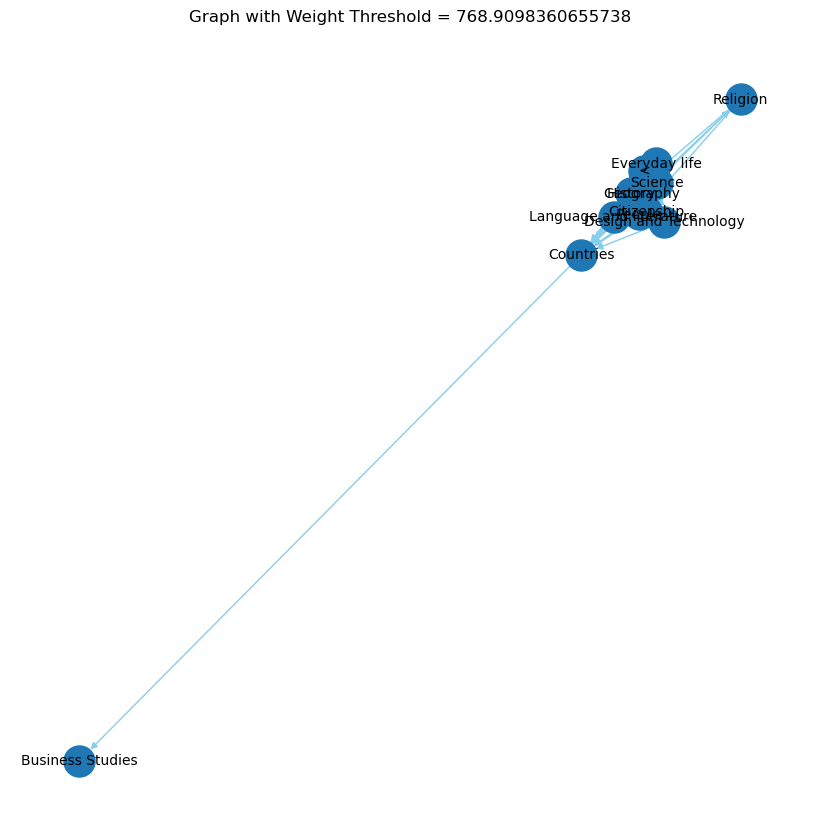

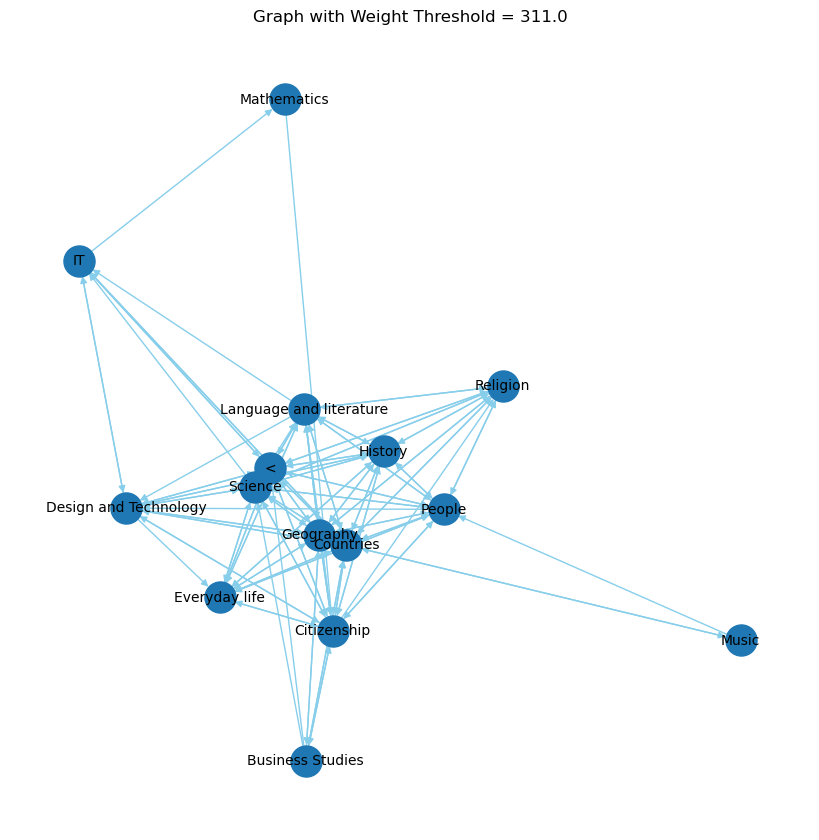

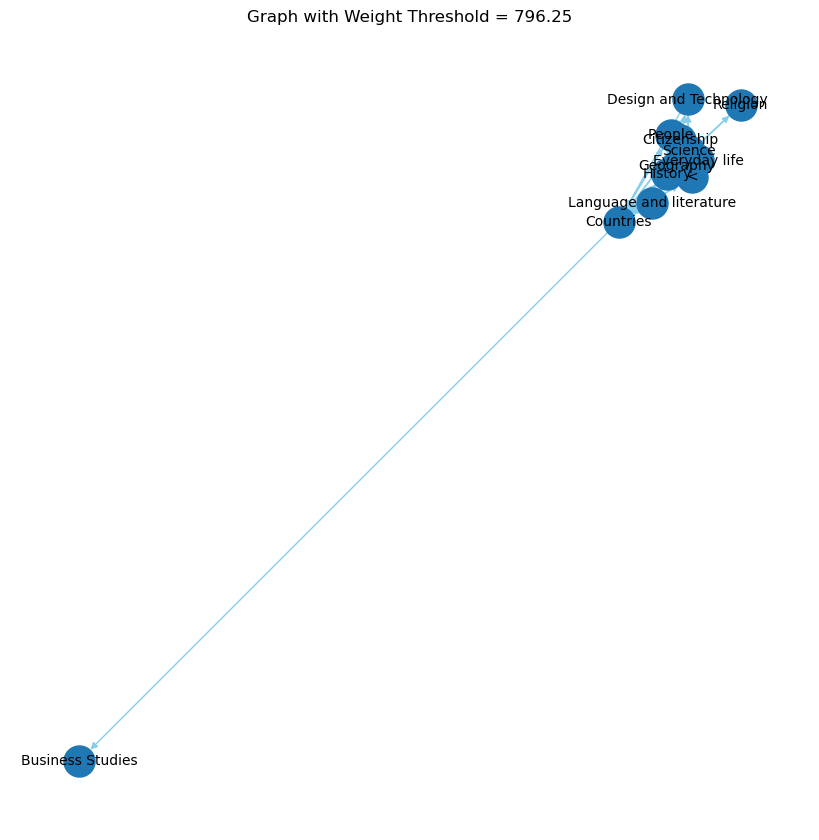

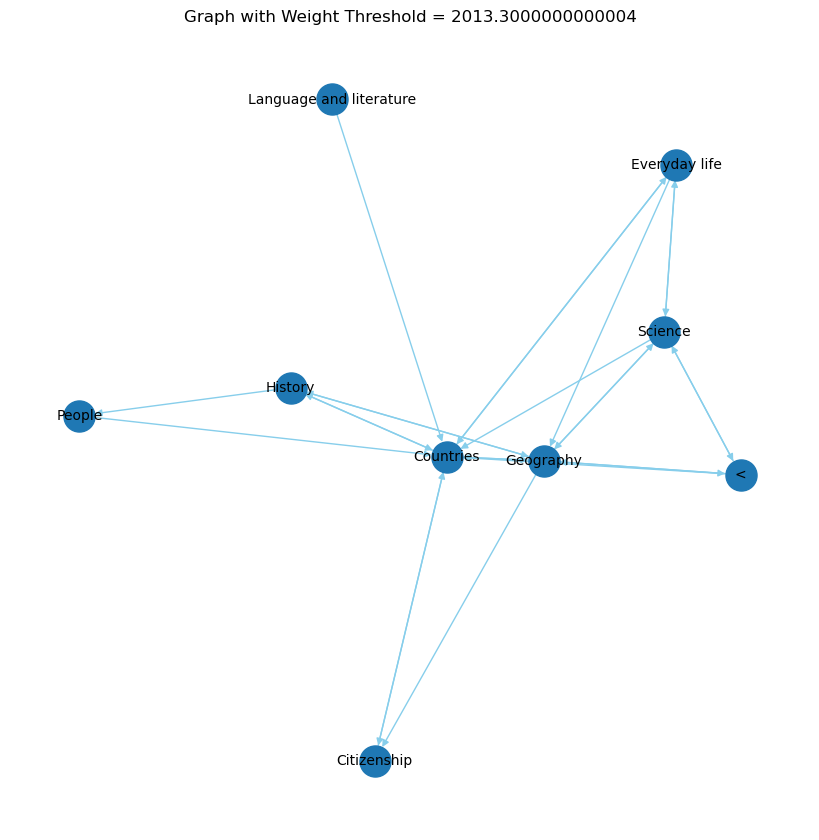

In [91]:
# Step 1: Build the network
G = build_network(df_finished, df_categories_filtered)

# Step 2: Filter and plot the network with a specific threshold and top connections
H = filter_network(G, weight_threshold=10, top_n=2)
plot_network(H, title="Filtered Network ")

# Step 3: Analyze edge weights and get thresholds (if want to explore different thresholds)
mean_weight, median_weight, percentile_75, percentile_90 = analyze_edge_weights(G)
plot_network_with_thresholds(G, [mean_weight, median_weight, percentile_75, percentile_90])

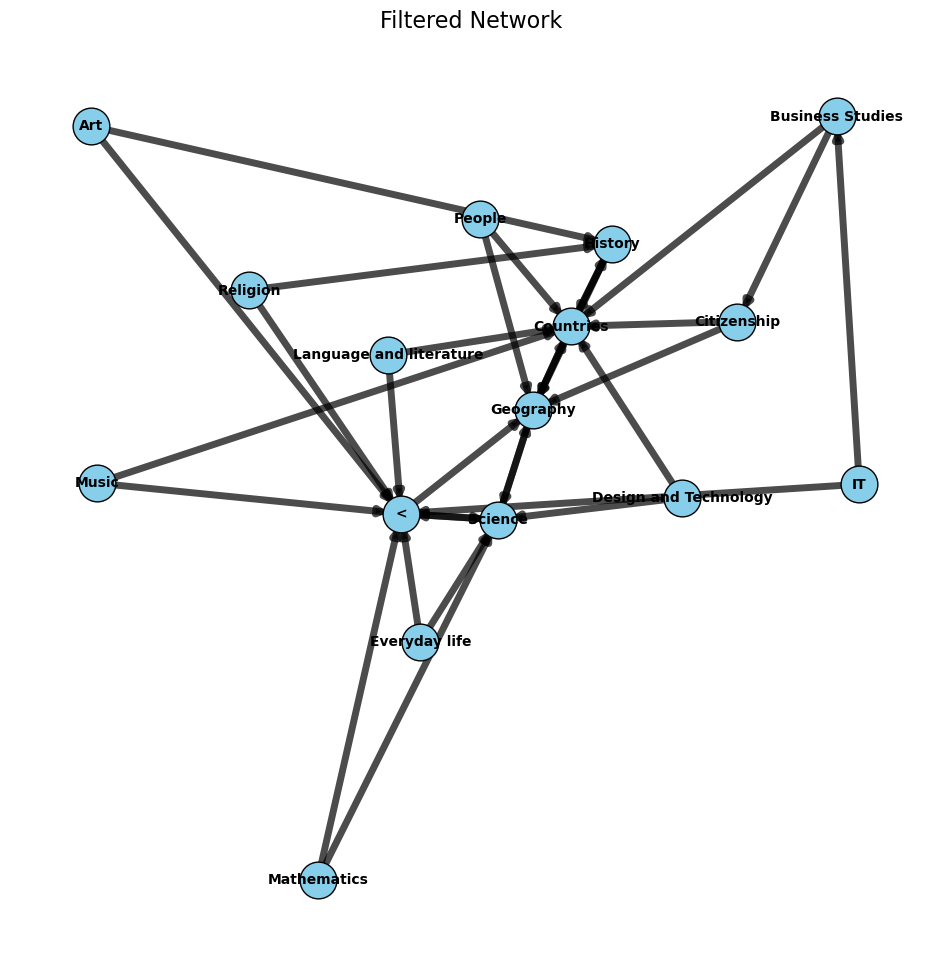

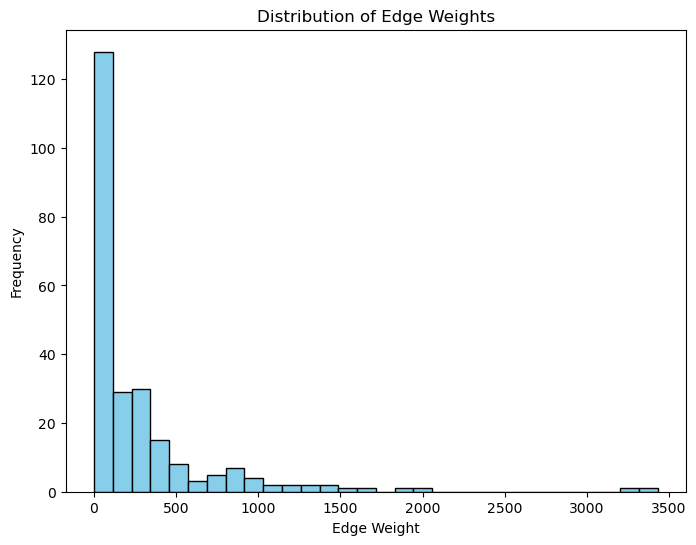

Mean Weight: 284.46090534979425
Median Weight: 109.0
75th Percentile: 318.0
90th Percentile: 803.4000000000001


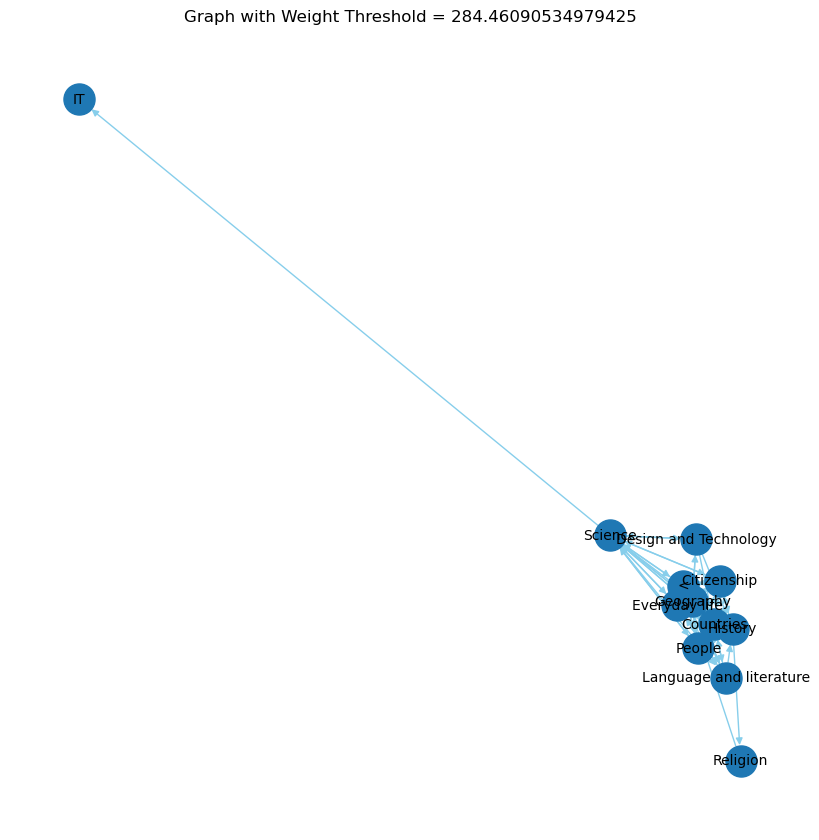

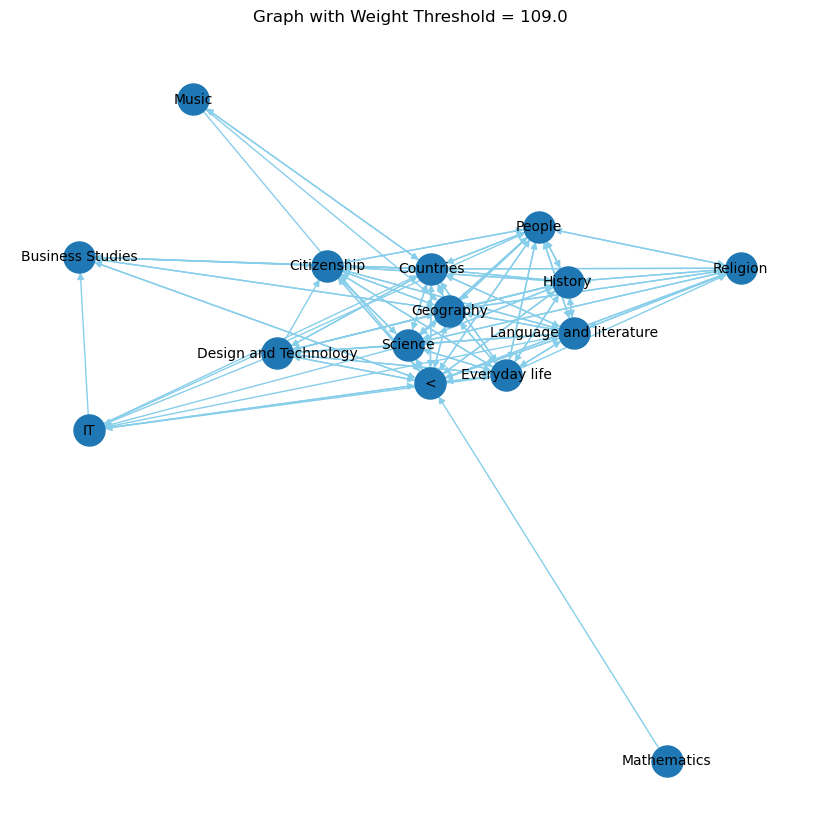

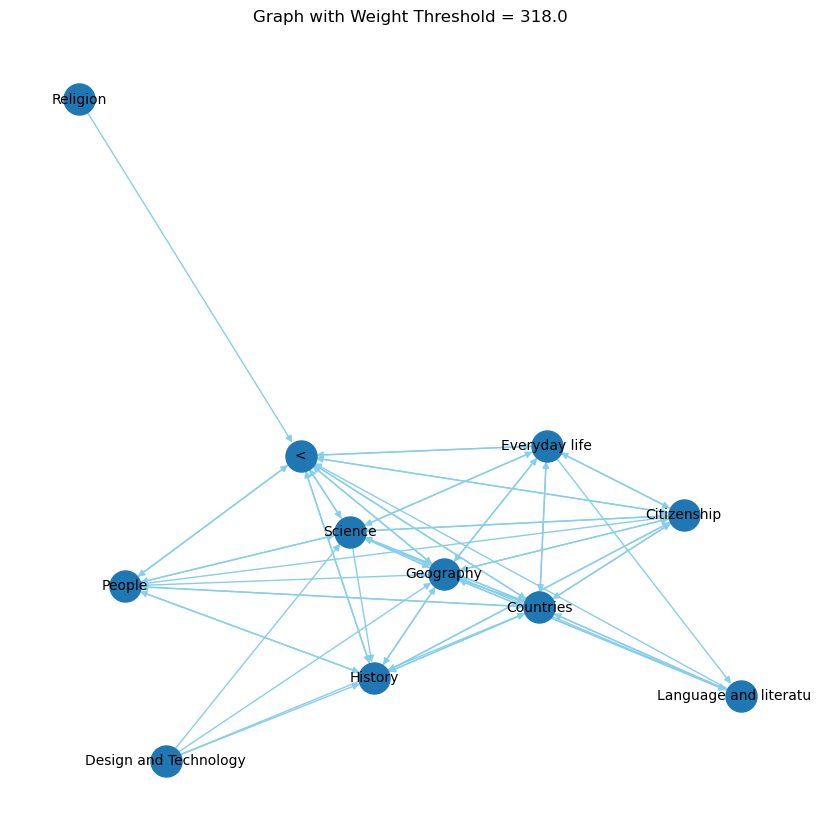

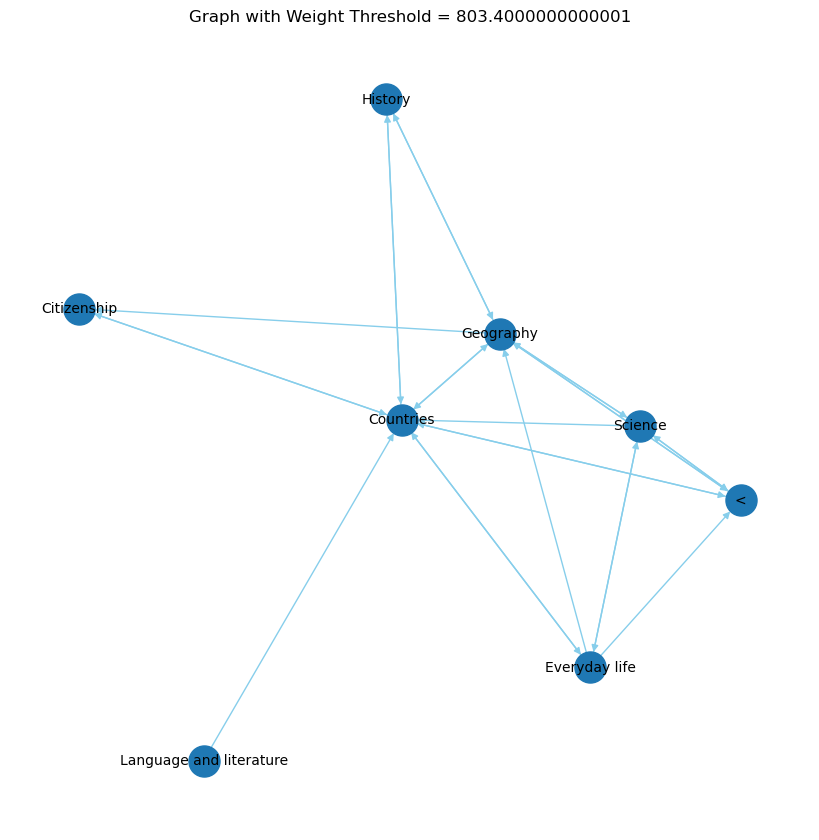

In [93]:
# Step 1: Build the network
G = build_network(df_unfinished, df_categories_filtered)

# Step 2: Filter and plot the network with a specific threshold and top connections
H = filter_network(G, weight_threshold=10, top_n=2)
plot_network(H, title="Filtered Network ")

# Step 3: Analyze edge weights and get thresholds (if want to explore different thresholds)
mean_weight, median_weight, percentile_75, percentile_90 = analyze_edge_weights(G)
plot_network_with_thresholds(G, [mean_weight, median_weight, percentile_75, percentile_90])